### GPU CHECKS AND IMPORTING DATA

All work was done in AWS, so google colab related code is removed as well as downloading of N-HPatches etc.

In [0]:
%cd keras_triplet_descriptor

!pip install humanize
!pip install talos
!pip install opencv-python
!pip install joblib
!pip install dill
!pip install tabulate
import humanize
import os
  
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random
import talos
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, Conv3D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
from keras.activations import sigmoid, relu, elu
from keras.layers.convolutional import Deconvolution2D
from talos import live, Reporting
from talos.model.normalizers import lr_normalizer
from keras.losses import mean_squared_error, binary_crossentropy

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

### TESTING BASELINE CODE

Declaring the data generators used for training and testing.

In [0]:
denoise_generator = DenoiseHPatches(seqs_train, batch_size = 50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size = 50)

100%|██████████| 40/40 [00:42<00:00,  1.16it/s]


Baseline architecture presented in this block.

In [0]:
def get_denoise_model_baseline(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net

In [0]:
get_denoise_model_baseline((32, 32, 1)).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
up_samplin

Compilation and training of the model using the baseline hyperparameters.

In [0]:
try: del denoise_model_baseline; print("Deleted previous model. Compiling a new one...")
except: print("The model has not been initialized. Compiling...")

shape = (32, 32, 1)
denoise_model_baseline = get_denoise_model_baseline(shape)

sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
denoise_model_baseline.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

The model has not been initialized. Compiling...


In [0]:
denoise_history_baseline = denoise_model_baseline.fit_generator(generator=denoise_generator, epochs=25, verbose=1, validation_data=denoise_generator_val)

Epoch 1/25
31179/31179 [==============================] - 193s 6ms/step - loss: 6.7265 - mean_absolute_error: 6.7265 - val_loss: 6.1578 - val_mean_absolute_error: 6.1578
Epoch 2/25
31179/31179 [==============================] - 192s 6ms/step - loss: 6.1571 - mean_absolute_error: 6.1571 - val_loss: 5.9866 - val_mean_absolute_error: 5.9866
Epoch 3/25
31179/31179 [==============================] - 192s 6ms/step - loss: 6.0108 - mean_absolute_error: 6.0108 - val_loss: 5.9835 - val_mean_absolute_error: 5.9835
Epoch 4/25
31179/31179 [==============================] - 193s 6ms/step - loss: 5.9268 - mean_absolute_error: 5.9268 - val_loss: 5.9722 - val_mean_absolute_error: 5.9722
Epoch 5/25
31179/31179 [==============================] - 192s 6ms/step - loss: 5.8672 - mean_absolute_error: 5.8672 - val_loss: 5.7407 - val_mean_absolute_error: 5.7407
Epoch 6/25
31179/31179 [==============================] - 192s 6ms/step - loss: 5.8209 - mean_absolute_error: 5.8209 - val_loss: 5.6893 - val_mean_abs

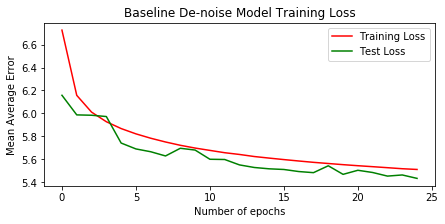

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize = (7, 3))
p1 = plt.plot(denoise_history_baseline.history['mean_absolute_error'], 'r')
p2 = plt.plot(denoise_history_baseline.history['val_mean_absolute_error'], 'g')
plt.title('Baseline De-noise Model Training Loss')
plt.ylabel('Mean Average Error')
plt.xlabel('Number of epochs')
plt.legend((p1[0], p2[0]), ('Training Loss', 'Test Loss'))

Generating training and testing data for the descriptor network using the denoising network.

In [0]:
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, denoise_model=denoise_model_baseline, use_clean=False)
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|██████████| 116/116 [00:35<00:00,  2.53it/s]
Denoising patches...
100%|██████████| 15589/15589 [01:14<00:00, 208.89it/s]


100%|██████████| 100000/100000 [00:01<00:00, 69201.18it/s]

Using denoised patches


100%|██████████| 116/116 [00:21<00:00,  5.48it/s]
Denoising patches...
100%|██████████| 9525/9525 [00:45<00:00, 207.83it/s]


100%|██████████| 10000/10000 [00:00<00:00, 61362.94it/s]


Baseline descriptor generating network defined.

In [0]:
def get_descriptor_model_baseline(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

def triplet_loss_baseline(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

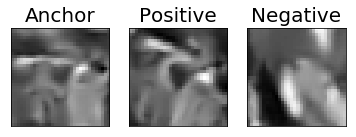

In [0]:
plot_triplet(training_generator)

Compilation and training of the descriptor network using predefined hyperparameters.

In [0]:
try: del descriptor_model_baseline; print("Deleted previous model. Compiling a new one...")
except: print("The model has not been initialized. Compiling...")

shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model_baseline = get_descriptor_model_baseline(shape)
ea = descriptor_model_baseline(xa)
ep = descriptor_model_baseline(xp)
en = descriptor_model_baseline(xn)

loss = Lambda(triplet_loss_baseline)([ea, ep, en])

descriptor_model_baseline_trip = Model(inputs=[xa, xp, xn], outputs=loss)

sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_baseline_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Deleted previous model. Compiling a new one...


In [0]:
descriptor_history_baseline_trip = descriptor_model_baseline_trip.fit_generator(generator=training_generator, epochs=25, verbose=1, validation_data=val_generator)

Epoch 1/25
1998/2000 [============================>.] - ETA: 0s - loss: 0.2136

  5%|▌         | 5204/100000 [00:00<00:05, 17417.18it/s]

2000/2000 [==============================] - 42s 21ms/step - loss: 0.2135 - val_loss: 0.2160


 12%|█▏        | 11742/100000 [00:00<00:04, 21264.31it/s]

Epoch 2/25


100%|██████████| 100000/100000 [00:03<00:00, 32362.44it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.1612 - val_loss: 0.2064


  3%|▎         | 2825/100000 [00:00<00:03, 28231.92it/s]

Epoch 3/25


100%|██████████| 100000/100000 [00:02<00:00, 34233.83it/s]A


2000/2000 [==============================] - 43s 22ms/step - loss: 0.1441 - val_loss: 0.2087


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 4/25


100%|██████████| 100000/100000 [00:02<00:00, 38416.47it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.1343 - val_loss: 0.1750


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 5/25


100%|██████████| 100000/100000 [00:02<00:00, 35977.63it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.1297 - val_loss: 0.1610


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 6/25


100%|██████████| 100000/100000 [00:02<00:00, 36804.61it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.1251 - val_loss: 0.1534


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 7/25


100%|██████████| 100000/100000 [00:02<00:00, 37065.87it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.1189 - val_loss: 0.1774


  4%|▎         | 3605/100000 [00:00<00:02, 36039.55it/s]

Epoch 8/25


100%|██████████| 100000/100000 [00:02<00:00, 35460.89it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.1176 - val_loss: 0.1409


  2%|▏         | 2232/100000 [00:00<00:04, 22291.06it/s]

Epoch 9/25


100%|██████████| 100000/100000 [00:02<00:00, 35748.06it/s]A


2000/2000 [==============================] - 43s 22ms/step - loss: 0.1123 - val_loss: 0.1330


  3%|▎         | 3432/100000 [00:00<00:02, 34293.21it/s]

Epoch 10/25


100%|██████████| 100000/100000 [00:02<00:00, 41255.79it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.1082 - val_loss: 0.1926


  2%|▏         | 2072/100000 [00:00<00:04, 20683.82it/s]

Epoch 11/25


100%|██████████| 100000/100000 [00:02<00:00, 36211.58it/s]


2000/2000 [==============================] - 42s 21ms/step - loss: 0.1056 - val_loss: 0.1402
Epoch 12/25


100%|██████████| 100000/100000 [00:02<00:00, 37797.19it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.1049 - val_loss: 0.1436
Epoch 13/25


100%|██████████| 100000/100000 [00:02<00:00, 45136.50it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.1016 - val_loss: 0.1333


  3%|▎         | 3367/100000 [00:00<00:02, 33664.65it/s]

Epoch 14/25


100%|██████████| 100000/100000 [00:02<00:00, 34508.18it/s]


2000/2000 [==============================] - 43s 21ms/step - loss: 0.1011 - val_loss: 0.1257


  4%|▎         | 3592/100000 [00:00<00:02, 35858.99it/s]

Epoch 15/25


100%|██████████| 100000/100000 [00:02<00:00, 34830.91it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.1014 - val_loss: 0.1450
Epoch 16/25


100%|██████████| 100000/100000 [00:02<00:00, 46350.33it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.0985 - val_loss: 0.1193


  4%|▍         | 3827/100000 [00:00<00:02, 38259.73it/s]

Epoch 17/25


100%|██████████| 100000/100000 [00:02<00:00, 36175.20it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.0951 - val_loss: 0.1449


  4%|▎         | 3512/100000 [00:00<00:02, 35114.01it/s]

Epoch 18/25


100%|██████████| 100000/100000 [00:02<00:00, 36271.82it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.0982 - val_loss: 0.1360


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 19/25


100%|██████████| 100000/100000 [00:02<00:00, 34999.47it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.0938 - val_loss: 0.1264


  3%|▎         | 3435/100000 [00:00<00:02, 34289.94it/s]

Epoch 20/25


100%|██████████| 100000/100000 [00:02<00:00, 34982.38it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.0927 - val_loss: 0.1421


  4%|▎         | 3705/100000 [00:00<00:02, 36963.49it/s]

Epoch 21/25


100%|██████████| 100000/100000 [00:02<00:00, 36042.52it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.0914 - val_loss: 0.1215


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 22/25


100%|██████████| 100000/100000 [00:02<00:00, 37504.65it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.0905 - val_loss: 0.1418


  4%|▎         | 3742/100000 [00:00<00:02, 37409.51it/s]

Epoch 23/25


100%|██████████| 100000/100000 [00:02<00:00, 35294.96it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.0876 - val_loss: 0.1193


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 24/25


100%|██████████| 100000/100000 [00:02<00:00, 37290.35it/s]A


2000/2000 [==============================] - 42s 21ms/step - loss: 0.0865 - val_loss: 0.1610


  2%|▏         | 2478/100000 [00:00<00:03, 24779.26it/s]

Epoch 25/25


100%|██████████| 100000/100000 [00:02<00:00, 36418.73it/s]A


2000/2000 [==============================] - 43s 21ms/step - loss: 0.0849 - val_loss: 0.1192


100%|██████████| 100000/100000 [00:02<00:00, 35917.13it/s]A


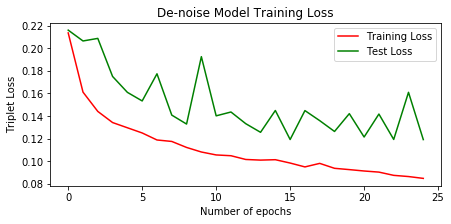

In [0]:
plt.figure(figsize = (7, 3))
p1 = plt.plot(descriptor_history_baseline_trip.history['loss'], 'r')
p2 = plt.plot(descriptor_history_baseline_trip.history['val_loss'], 'g')
plt.title('Baseline Descriptor Model Training Loss')
plt.ylabel('Triplet Loss')
plt.xlabel('Number of epochs')
plt.legend((p1[0], p2[0]), ('Training Loss', 'Test Loss'))

Evaluating the full system using verification, retrieval and matching metrics.

In [0]:
generate_desc_csv(descriptor_model_baseline, seqs_test, denoise_model = denoise_model_baseline, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval


100%|██████████| 40/40 [02:44<00:00,  3.36s/it]


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 3/3 : 100%|██████████| 1000000/1000000 [01:11<00:00, 13962.32it/s]
>> Verification task finished in 219 secs  
Verification task results:
Mean Average Precision is 0.828843



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100%|██████████| 40/40 [01:50<00:00,  3.73s/it]
>> Matching task finished in 111 secs  
Matching task results:
Mean Average Precision is 0.238495





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
Processing retrieval task: 100%|██████████| 10000/10000 [03:34<00:00, 46.76it/s]
>> Retrieval task finished in 230 secs  
Retrieval task